In [1]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import random

# Deep Learning for NLP - lab exercise 1
In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence, and a classifier based on a convolutional neural network (CNN). The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!
We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:

- turorials: http://pytorch.org/tutorials/
- documentation: http://pytorch.org/docs/master/

# Data
The data can be download here: http://caio-corro.fr/dl4nlp/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.

The following functions can be used to load and clean the data.

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    dataset=[]
    with open(filename) as f:
        line = f.readline()
        cpt=1
        skip=0
        while line :
            cleanline = clean_str(f.readline()).split()
            if cleanline: 
                dataset.append(cleanline)
            else: 
                line = f.readline()
                skip+=1
                continue
            if limit > 0 and cpt >= limit: 
                break
            line = f.readline()
            cpt+=1        

        print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset

<>:16: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\)'
<>:18: SyntaxWarning: invalid escape sequence '\?'
<>:16: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\)'
<>:18: SyntaxWarning: invalid escape sequence '\?'
C:\Users\marin\AppData\Local\Temp\ipykernel_33224\1674527786.py:16: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
C:\Users\marin\AppData\Local\Temp\ipykernel_33224\1674527786.py:17: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
C:\Users\marin\AppData\Local\Temp\ipykernel_33224\1674527786.py:18: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


In [3]:
# The following cell load the first 5000 sentences in each review set.
LIM = 5000
txtfile = "imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = "imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


In [4]:
n_train = int(0.8 * LIM)
n_dev = int(0.1 * LIM)
n_test = LIM - n_train - n_dev
txt_train = postxt[:n_train] + negtxt[:n_train]
label_train = [1]*n_train + [0]*n_train
txt_dev = postxt[n_train:n_train+n_dev] + negtxt[n_train:n_train+n_dev]
label_dev = [1]*n_dev + [0]*n_dev   
txt_test = postxt[n_train+n_dev:] + negtxt[n_train+n_dev:]
label_test = [1]*n_test + [0]*n_test


# Converting data to Pytorch tensors
We will first convert data to Pytorch tensors so they can be used in a neural network. To do that, you must first create a dictionnary that will map words to integers. Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:

- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient  

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4]. Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words) You can just skip them, even if this is a bad idea in general.

In [5]:
# Build a vocabulary from the training set only
word2idx = {}
idx2word = {}
current_idx = 0

for sentence in txt_train:
    for word in sentence:
        if word not in word2idx:
            word2idx[word] = current_idx
            idx2word[current_idx] = word
            current_idx += 1

print(f"Vocabulary size: {len(word2idx)} words")

# Function to convert sentences into lists of indices
def sentence_to_indices(sentence, word2idx):
    indices = []
    for word in sentence:
        if word in word2idx:
            indices.append(word2idx[word])
    return indices

X_train_idx = [sentence_to_indices(s, word2idx) for s in txt_train]
X_dev_idx   = [sentence_to_indices(s, word2idx) for s in txt_dev]
X_test_idx  = [sentence_to_indices(s, word2idx) for s in txt_test]

y_train = th.tensor(label_train, dtype=th.long, requires_grad=False)
y_dev   = th.tensor(label_dev, dtype=th.long, requires_grad=False)
y_test  = th.tensor(label_test, dtype=th.long, requires_grad=False)

X_train = [th.tensor(s, dtype=th.long, requires_grad=False) for s in X_train_idx]
X_dev   = [th.tensor(s, dtype=th.long, requires_grad=False) for s in X_dev_idx]
X_test  = [th.tensor(s, dtype=th.long, requires_grad=False) for s in X_test_idx]

# Check an example
exx = 5
print("Example sentence:", txt_train[exx])
print("As indices:", X_train[exx])
print("Label:", y_train[exx])


Vocabulary size: 6997 words
Example sentence: ['mike', 'leigh', "'s", 'best', 'and', 'the', 'best', 'of', '2010']
As indices: tensor([23, 24, 25, 26, 16, 27, 26,  8, 28])
Label: tensor(1)


# Neural network definition
You need to implement two networks:

- a simple bag of word model (note: it may be better to take the mean of input embeddings that the sum)
- a simple CNN as described in the course  

To simplify code, you can assume the input will always be a single sentence first, and then implement batched inputs. In the case of batched inputs, give to the forward function a (python) list of tensors.

The bag of word neural network should be defined as follows:

- take as input a tensor that is a sequence of integers indexing word embeddings
- retrieve the word embeddings from an embedding table
- construct the "input" of the MLP by summing (or computing the mean) over all embeddings (i.e. bag-of-word model)
- build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).  

The CNN is a little bit more tricky to implement. The goal is that you implement the one presented in the first lecture. Importantly, you should add "padding" tokens before and after the sentence so you can have a convolution even when there is a single word in the input. For example, if you input sentence is ["word"], you want to instead consider the sentence ["<BOS>", "word", "<EOS>"] if your window is of size 2 or 3. You can do this either directly when you load the data, or you can do that in the neural network module.

# Loss function
Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in BCELoss and BCEWithLogitsLoss. Read their documentation and choose the one that fits with your network output

# Training loop
Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

# BAG of word classifier

Training on cuda
Epoch 01 | Mean loss = 0.1762 | Dev accuracy = 49.80%
Epoch 02 | Mean loss = 0.1361 | Dev accuracy = 49.80%
Epoch 03 | Mean loss = 0.0927 | Dev accuracy = 50.20%
Epoch 04 | Mean loss = 0.0676 | Dev accuracy = 50.10%
Epoch 05 | Mean loss = 0.0511 | Dev accuracy = 50.80%


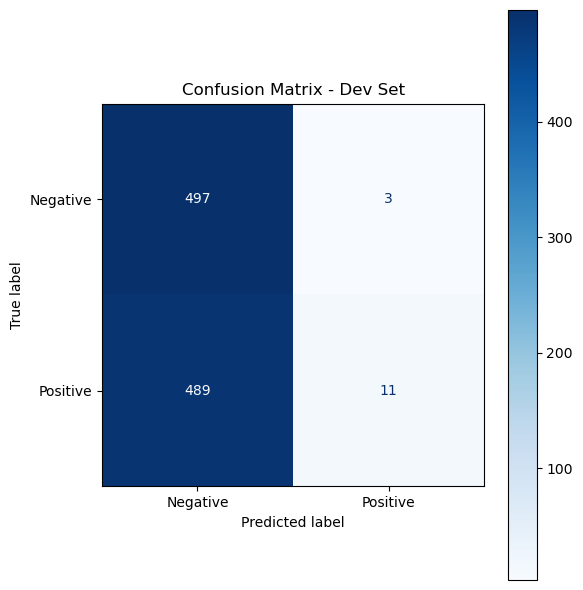

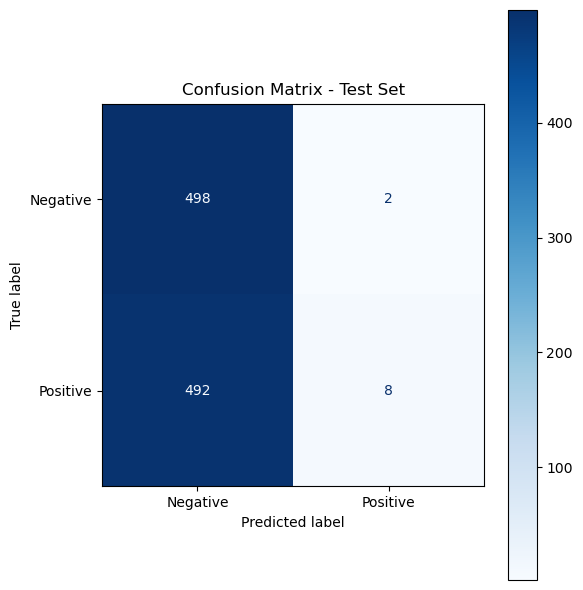

In [6]:
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=None):
        super(CBOW_classifier, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        if hidden_dim is None:
            self.fc = nn.Linear(embedding_dim, 1)
        else:
            self.fc1 = nn.Linear(embedding_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, 1)

        self.hidden_dim = hidden_dim

    def forward(self, inputs):
        if isinstance(inputs, list):
            outputs = []
            for sent in inputs:
                emb = self.embeddings(sent)         
                mean_emb = emb.mean(dim=0)          
                if self.hidden_dim is None:
                    out = self.fc(mean_emb)
                else:
                    h = F.relu(self.fc1(mean_emb))
                    out = self.fc2(h)
                outputs.append(out)
            return th.cat(outputs).squeeze()

        else:
            emb = self.embeddings(inputs)       
            mean_emb = emb.mean(dim=0)
            if self.hidden_dim is None:
                out = self.fc(mean_emb)
            else:
                h = F.relu(self.fc1(mean_emb))
                out = self.fc2(h)
            return out.squeeze()

def build_loss():
    """
    Return the loss function used for binary classification.
    Since our network outputs logits (not probabilities), we use BCEWithLogitsLoss.
    """
    return nn.BCEWithLogitsLoss()

def plot_confusion_matrix_CBOW(model, X_data, y_data, device, title="Confusion Matrix"):
    """
    Plot the confusion matrix for the given model and data.
    
    Args:
        model: trained CBOW_classifier
        X_data: input data (list of tensors)
        y_data: true labels (tensor)
        device: torch device (cpu or cuda)
        title: title for the plot
    """
    model.eval()
    y_true = []
    y_pred = []
    
    with th.no_grad():
        for sentence, label in zip(X_data, y_data):
            sentence = sentence.to(device) 
            out = model(sentence)
            pred = th.sigmoid(out).item() >= 0.5
            y_true.append(label.item())
            y_pred.append(int(pred))
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

def train_model(model, X_train, y_train, X_dev, y_dev, n_epochs=10, lr=1e-3):
    """
    Train a CBOW bag-of-words classifier.

    Args:
        model: instance of CBOW_classifier
        X_train, y_train: training data
        X_dev, y_dev: dev data
        n_epochs: number of epochs
        lr: learning rate
    """
    device = th.device('cuda' if th.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Training on {device}")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0.0

        for i, (sentence, label) in enumerate(zip(X_train, y_train)):
            optimizer.zero_grad()

            sentence = sentence.to(device)
            label = label.to(device).float()

            output = model(sentence)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / len(X_train)

        # Evaluation on the dev set
        model.eval()
        correct = 0
        with th.no_grad():
            for sentence, label in zip(X_dev, y_dev):
                sentence = sentence.to(device) 
                out = model(sentence)
                pred = th.sigmoid(out).item() >= 0.5 
                if pred == bool(label.item()):
                    correct += 1
        acc = correct / len(X_dev)

        print(f"Epoch {epoch:02d} | Mean loss = {mean_loss:.4f} | Dev accuracy = {acc*100:.2f}%")
    
    return model, device


vocab_size = len(word2idx)
embedding_dim = 100

model = CBOW_classifier(vocab_size, embedding_dim)
model, device = train_model(model, X_train, y_train, X_dev, y_dev, n_epochs=5, lr=1e-3)

plot_confusion_matrix_CBOW(model, X_dev, y_dev, device, title="Confusion Matrix - Dev Set")
plot_confusion_matrix_CBOW(model, X_test, y_test, device, title="Confusion Matrix - Test Set")

# CNN

In [7]:
class SentimentCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_filters=100, window_size=3, dropout=0.5):
        """
        CNN for sentiment analysis.
        
        Args:
            vocab_size: vocabulary size
            embed_dim: embeddings dimension
            num_filters: number of convolution filters
            window_size: size of the convolution window
            dropout: dropout rate
        """
        super(SentimentCNN, self).__init__()
        
        self.window_size = window_size
        self.vocab_size = vocab_size
        
        # Special tokens indices
        self.pad_idx = vocab_size  # <PAD>
        self.bos_idx = vocab_size + 1  # <BOS>
        self.eos_idx = vocab_size + 2  # <EOS>
        
        # Embedding layer (vocab_size + 3 for PAD, BOS, EOS)
        self.embedding = nn.Embedding(vocab_size + 3, embed_dim, padding_idx=self.pad_idx)
        
        self.conv = nn.Conv1d(in_channels=embed_dim, 
                             out_channels=num_filters, 
                             kernel_size=window_size)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(num_filters, 1)
        
    def add_padding(self, sentence_tensor):
        """
        Add BOS and EOS tokens at the beginning and end
        """
        bos = th.tensor([self.bos_idx], dtype=th.long, device=sentence_tensor.device)
        eos = th.tensor([self.eos_idx], dtype=th.long, device=sentence_tensor.device)
        return th.cat([bos, sentence_tensor, eos])
    
    def forward(self, sentences):
        """
        Forward pass
        
        Args:
            sentences: list of tensors (each tensor = a sentence with word indices)
        
        Returns:
            logits: tensor of shape (batch_size, 1)
        """
        padded_sentences = [self.add_padding(s) for s in sentences]
        
        max_len = max(len(s) for s in padded_sentences)
        
        batch_size = len(sentences)
        batch = th.full((batch_size, max_len), self.pad_idx, dtype=th.long, device=sentences[0].device)
        
        for i, s in enumerate(padded_sentences):
            batch[i, :len(s)] = s
        
        embedded = self.embedding(batch)
        embedded = embedded.transpose(1, 2)
        conv_out = F.relu(self.conv(embedded))
        pooled = F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)
        dropped = self.dropout(pooled)
        logits = self.fc(dropped)
        
        return logits.squeeze(1)


def train_epoch(model, X_data, y_data, optimizer, criterion, batch_size=32):
    """
    Train the model for one epoch
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    indices = th.randperm(len(X_data))
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for i in range(num_batches):
        batch_indices = indices[i * batch_size : (i + 1) * batch_size]
        X_batch = [X_data[idx] for idx in batch_indices]
        y_batch = y_data[batch_indices]
        
        optimizer.zero_grad()
        logits = model(X_batch)

        loss = criterion(logits, y_batch.float())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = (th.sigmoid(logits) > 0.5).long()
        correct += (predictions == y_batch).sum().item()
        total += len(y_batch)
    
    avg_loss = total_loss / num_batches
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, X_data, y_data, criterion, batch_size=32):
    """
    Evaluate the model on a dataset
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    with th.no_grad():
        for i in range(num_batches):
            X_batch = X_data[i * batch_size : (i + 1) * batch_size]
            y_batch = y_data[i * batch_size : (i + 1) * batch_size]
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.float())
            
            total_loss += loss.item()
            predictions = (th.sigmoid(logits) > 0.5).long()
            correct += (predictions == y_batch).sum().item()
            total += len(y_batch)
    
    avg_loss = total_loss / num_batches
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


# ===============================
# TRAINING LOOP
# ===============================

# Hyperparameters
VOCAB_SIZE = len(word2idx)
EMBED_DIM = 32
NUM_FILTERS = 200
WINDOW_SIZE = 3
DROPOUT = 0.5
LEARNING_RATE = 0.001
BATCH_SIZE = 16
NUM_EPOCHS = 10

model = SentimentCNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_filters=NUM_FILTERS,
    window_size=WINDOW_SIZE,
    dropout=DROPOUT
)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = model.to(device)

X_train = [x.to(device) for x in X_train]
X_dev = [x.to(device) for x in X_dev]
X_test = [x.to(device) for x in X_test]
y_train = y_train.to(device)
y_dev = y_dev.to(device)
y_test = y_test.to(device)

print(f"Training on {device}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Training samples: {len(X_train)}")
print(f"Dev samples: {len(X_dev)}")
print(f"Test samples: {len(X_test)}")
print("-" * 60)

best_dev_acc = 0
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, X_train, y_train, optimizer, criterion, BATCH_SIZE)
    
    dev_loss, dev_acc = evaluate(model, X_dev, y_dev, criterion, BATCH_SIZE)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Dev Loss:   {dev_loss:.4f} | Dev Acc:   {dev_acc:.2f}%")
    
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        th.save(model.state_dict(), 'best_cnn_model.pt')
    print("-" * 60)


print("\n" + "=" * 60)
print("EVALUATION ON TEST SET")
print("=" * 60)

model.load_state_dict(th.load('best_cnn_model.pt'))
test_loss, test_acc = evaluate(model, X_test, y_test, criterion, BATCH_SIZE)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


# Prediction example
model.eval()
with th.no_grad():
    example_idx = 5
    example_sentence = txt_train[example_idx]
    example_tensor = X_train[example_idx]
    logit = model([example_tensor])
    prob = th.sigmoid(logit).item()
    pred = 1 if prob > 0.5 else 0
    
    print("\n" + "=" * 60)
    print("EXAMPLE PREDICTION")
    print("=" * 60)
    print(f"Sentence: {' '.join(example_sentence[:20])}...")
    print(f"True label: {'Positive' if y_train[example_idx].item() == 1 else 'Negative'}")
    print(f"Predicted: {'Positive' if pred == 1 else 'Negative'}")
    print(f"Confidence: {prob:.4f}")


Training on cuda
Vocabulary size: 6997
Training samples: 8000
Dev samples: 1000
Test samples: 1000
------------------------------------------------------------
Epoch 1/10
  Train Loss: 0.6638 | Train Acc: 58.41%
  Dev Loss:   0.6074 | Dev Acc:   65.50%
------------------------------------------------------------
Epoch 2/10
  Train Loss: 0.5645 | Train Acc: 69.51%
  Dev Loss:   0.5608 | Dev Acc:   69.70%
------------------------------------------------------------
Epoch 3/10
  Train Loss: 0.4918 | Train Acc: 75.59%
  Dev Loss:   0.5306 | Dev Acc:   71.80%
------------------------------------------------------------
Epoch 4/10
  Train Loss: 0.4302 | Train Acc: 79.85%
  Dev Loss:   0.5225 | Dev Acc:   74.90%
------------------------------------------------------------
Epoch 5/10
  Train Loss: 0.3837 | Train Acc: 82.72%
  Dev Loss:   0.5239 | Dev Acc:   73.80%
------------------------------------------------------------
Epoch 6/10
  Train Loss: 0.3370 | Train Acc: 85.81%
  Dev Loss:   0.51

C:\Users\marin\AppData\Local\Temp\ipykernel_33224\3433575825.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('best_cnn_model.pt'))


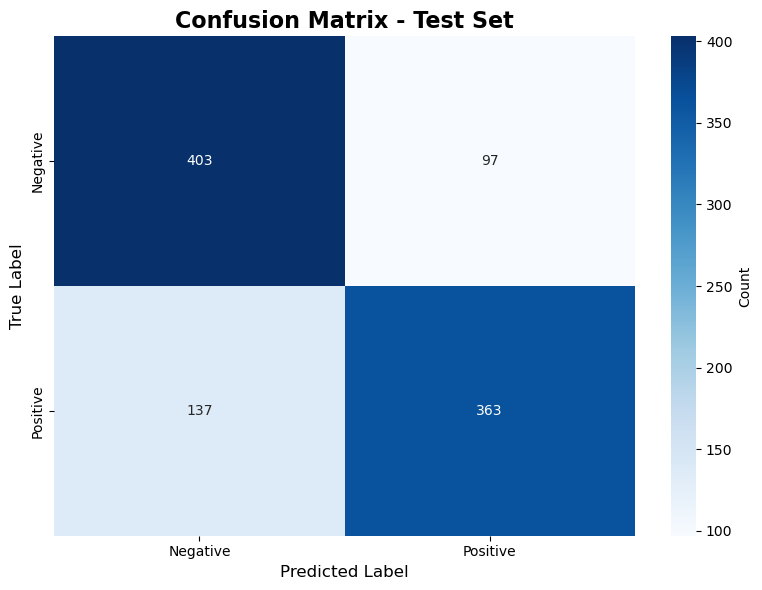


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.7463    0.8060    0.7750       500
    Positive     0.7891    0.7260    0.7562       500

    accuracy                         0.7660      1000
   macro avg     0.7677    0.7660    0.7656      1000
weighted avg     0.7677    0.7660    0.7656      1000



In [8]:
def get_all_predictions(model, X_data, y_data, batch_size=32):
    """
    Get all predictions for a dataset
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    with th.no_grad():
        for i in range(num_batches):
            X_batch = X_data[i * batch_size : (i + 1) * batch_size]
            y_batch = y_data[i * batch_size : (i + 1) * batch_size]
            
            logits = model(X_batch)
            predictions = (th.sigmoid(logits) > 0.5).long()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)


y_true, y_pred = get_all_predictions(model, X_test, y_test, BATCH_SIZE)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_true, y_pred, 
                          target_names=['Negative', 'Positive'],
                          digits=4))


### Hyperparams

Device: cuda
Vocabulary size: 6997
Training samples: 8000
Dev samples: 1000
Test samples: 1000
RANDOM SEARCH - 20 configurations

[1/20] Testing configuration:
  embed_dim=32, num_filters=150, window_size=2, dropout=0.30
  learning_rate=0.001, batch_size=16
 Dev Accuracy: 76.40%
  NEW BEST MODEL!

[2/20] Testing configuration:
  embed_dim=256, num_filters=200, window_size=3, dropout=0.40
  learning_rate=0.001, batch_size=16
 Dev Accuracy: 77.80%
  NEW BEST MODEL!

[3/20] Testing configuration:
  embed_dim=128, num_filters=100, window_size=5, dropout=0.40
  learning_rate=0.0001, batch_size=32
 Dev Accuracy: 72.00%

[4/20] Testing configuration:
  embed_dim=128, num_filters=200, window_size=3, dropout=0.50
  learning_rate=0.0001, batch_size=16
 Dev Accuracy: 75.40%

[5/20] Testing configuration:
  embed_dim=128, num_filters=100, window_size=2, dropout=0.40
  learning_rate=0.0005, batch_size=64
 Dev Accuracy: 74.30%

[6/20] Testing configuration:
  embed_dim=32, num_filters=50, window_siz

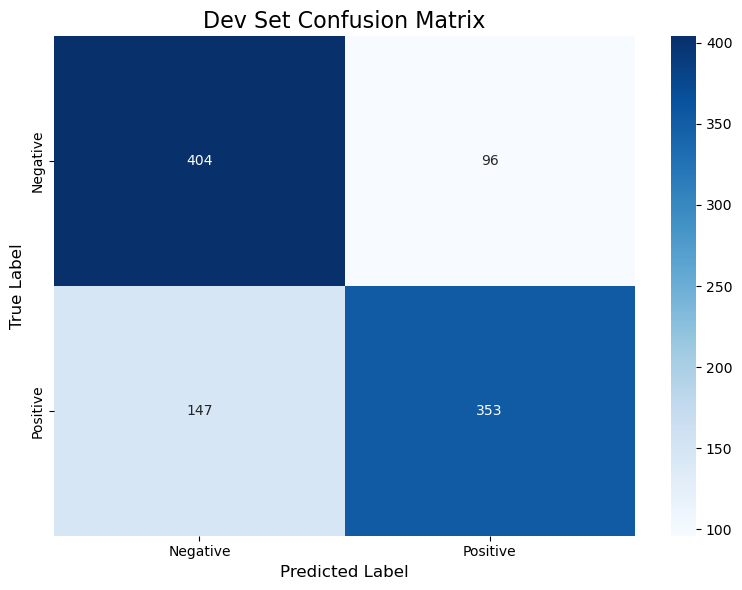


Dev Set Confusion Matrix - Classification Report:
              precision    recall  f1-score   support

    Negative     0.7332    0.8080    0.7688       500
    Positive     0.7862    0.7060    0.7439       500

    accuracy                         0.7570      1000
   macro avg     0.7597    0.7570    0.7564      1000
weighted avg     0.7597    0.7570    0.7564      1000



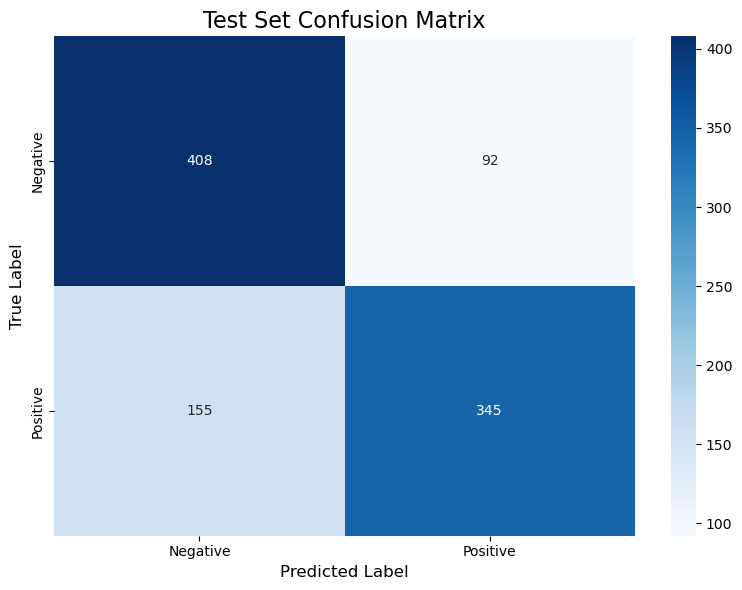


Test Set Confusion Matrix - Classification Report:
              precision    recall  f1-score   support

    Negative     0.7247    0.8160    0.7676       500
    Positive     0.7895    0.6900    0.7364       500

    accuracy                         0.7530      1000
   macro avg     0.7571    0.7530    0.7520      1000
weighted avg     0.7571    0.7530    0.7520      1000



In [ ]:
def train_model_with_config(config, X_train, y_train, X_dev, y_dev, vocab_size, device, num_epochs=10):
    """
    Train a SentimentCNN model with the given hyperparameter configuration.
    """
    model = SentimentCNN(
        vocab_size=vocab_size,
        embed_dim=config['embed_dim'],
        num_filters=config['num_filters'],
        window_size=config['window_size'],
        dropout=config['dropout']
    )
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    model = model.to(device)
    
    best_dev_acc = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, X_train, y_train, optimizer, criterion, config['batch_size'])
        dev_loss, dev_acc = evaluate(model, X_dev, y_dev, criterion, config['batch_size'])
        
        if dev_acc > best_dev_acc:
            best_dev_acc = dev_acc
    
    return best_dev_acc, model


def random_search(X_train, y_train, X_dev, y_dev, vocab_size, device, n_iter=20, num_epochs=10):
    """
    Random search to find the best hyperparameters
    """
    # Define the search spaces
    param_distributions = {
        'embed_dim': [32, 64, 128, 256],
        'num_filters': [50, 100, 150, 200],
        'window_size': [2, 3, 4, 5],
        'dropout': [0.3, 0.4, 0.5, 0.6],
        'learning_rate': [0.0001, 0.0005, 0.001, 0.005],
        'batch_size': [16, 32, 64]
    }
    
    results = []
    best_score = 0
    best_config = None
    best_model = None
    
    print("=" * 80)
    print(f"RANDOM SEARCH - {n_iter} configurations")
    print("=" * 80)
    
    for i in range(n_iter):
        config = {
            'embed_dim': random.choice(param_distributions['embed_dim']),
            'num_filters': random.choice(param_distributions['num_filters']),
            'window_size': random.choice(param_distributions['window_size']),
            'dropout': random.choice(param_distributions['dropout']),
            'learning_rate': random.choice(param_distributions['learning_rate']),
            'batch_size': random.choice(param_distributions['batch_size'])
        }
        
        print(f"\n[{i+1}/{n_iter}] Testing configuration:")
        print(f"  embed_dim={config['embed_dim']}, num_filters={config['num_filters']}, "
              f"window_size={config['window_size']}, dropout={config['dropout']:.2f}")
        print(f"  learning_rate={config['learning_rate']}, batch_size={config['batch_size']}")
        
        # Train the model
        dev_acc, model = train_model_with_config(config, X_train, y_train, X_dev, y_dev, 
                                                   vocab_size, device, num_epochs)
        
        print(f" Dev Accuracy: {dev_acc:.2f}%")
        
        results.append({
            'config': config,
            'dev_acc': dev_acc
        })
        
        if dev_acc > best_score:
            best_score = dev_acc
            best_config = config
            best_model = model
            print(f"  NEW BEST MODEL!")
    
    return best_config, best_score, best_model, results


# ===============================
# RANDOM SEARCH
# ===============================

VOCAB_SIZE = len(word2idx)
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

X_train = [x.to(device) for x in X_train]
X_dev = [x.to(device) for x in X_dev]
X_test = [x.to(device) for x in X_test]
y_train = y_train.to(device)
y_dev = y_dev.to(device)
y_test = y_test.to(device)

print(f"Device: {device}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Training samples: {len(X_train)}")
print(f"Dev samples: {len(X_dev)}")
print(f"Test samples: {len(X_test)}")

N_ITER = 20  # Number of configurations to try
NUM_EPOCHS = 8  # Number of epochs per configuration

best_config, best_score, best_model, results = random_search(
    X_train, y_train, X_dev, y_dev, VOCAB_SIZE, device, 
    n_iter=N_ITER, num_epochs=NUM_EPOCHS
)


print("\n" + "=" * 80)
print("RANDOM SEARCH RESULTS")
print("=" * 80)

results_sorted = sorted(results, key=lambda x: x['dev_acc'], reverse=True)

print("\nTop 3 configurations:")
for i, result in enumerate(results_sorted[:3]):
    config = result['config']
    print(f"\n{i+1}. Dev Acc: {result['dev_acc']:.2f}%")
    print(f"   embed_dim={config['embed_dim']}, num_filters={config['num_filters']}, "
          f"window_size={config['window_size']}")
    print(f"   dropout={config['dropout']:.2f}, lr={config['learning_rate']}, batch_size={config['batch_size']}")

print("\n" + "=" * 80)
print("BEST CONFIGURATION")
print("=" * 80)
print(f"Dev Accuracy: {best_score:.2f}%")
print(f"Configuration:")
for key, value in best_config.items():
    print(f"  {key}: {value}")

# Evaluate on the test set
print("\n" + "=" * 80)
print("EVALUATION ON TEST SET")
print("=" * 80)

criterion = nn.BCEWithLogitsLoss()
test_loss, test_acc = evaluate(best_model, X_test, y_test, criterion, best_config['batch_size'])
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Save the best model
th.save({
    'model_state_dict': best_model.state_dict(),
    'config': best_config,
    'dev_acc': best_score,
    'test_acc': test_acc
}, 'best_cnn_random_search.pt')


def plot_confusion_matrix(model, X_data, y_data, batch_size=32, title='Confusion Matrix'):
    """
    Calculate and display the confusion matrix
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    with th.no_grad():
        for i in range(num_batches):
            X_batch = X_data[i * batch_size : (i + 1) * batch_size]
            y_batch = y_data[i * batch_size : (i + 1) * batch_size]
            
            logits = model(X_batch)
            predictions = (th.sigmoid(logits) > 0.5).long()
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=150)
    plt.show()
    
    print(f"\n{title} - Classification Report:")
    print(classification_report(all_labels, all_preds, 
                                target_names=['Negative', 'Positive'],
                                digits=4))
    
    return cm


# Confusion matrix on the dev set
cm_dev = plot_confusion_matrix(best_model, X_dev, y_dev, 
                                batch_size=best_config['batch_size'],
                                title='Dev Set Confusion Matrix')

# Confusion matrix on the test set
cm_test = plot_confusion_matrix(best_model, X_test, y_test, 
                                 batch_size=best_config['batch_size'],
                                 title='Test Set Confusion Matrix')